In [1]:
import numpy as np
from simfloat import *
import matplotlib.pyplot as plt

%matplotlib inline

# 基础研究方法说明

研究目标: 影响向量内积计算的浮点数量化误差的主要因素
LLM中主要的计算是矩阵乘法，而矩阵乘法可以看做是由向量内积构成的，因此我们主要研究：
1. 向量内积的浮点数量化误差受向量长度的影响；
2. 向量相关性对浮点数量化误差的影响；

## SIMFLOAT的使用

### 使用content定义浮点数
浮点数主要由三部分构成：
1. 符号位，通常为1 bit，0表示正数，1表示负数；
2. 指数位 (Exponent)：用于表示数值的量级
3. 尾数位 (Mantissa/Significand)：表示实际的数值精度

常见的浮点数类型的定义：
1. double（float64）：1s 11e 52m
2. single（float32）：1s 8e 23m
3. half（float16）：1s 5e 10m
4. bfloat16：1s 8e 7m

可以使用simfloat自定义一个浮点类型：

In [2]:
ftype = define_context(4, 3)
print(ftype(1.1))
print(ftype(1.1).as_decimal())

0 0111 001
1.125


### 使用simfloat进行浮点数运算

我们可以借助simfloat来进行浮点数运算，只需要定义两个浮点数，然后直接进行一些基础运算即可:

In [3]:
ftype = define_context(4, 3)
a = ftype(1.0)
b = ftype(2.0)
print(a+b)
print((a+b).as_decimal())

0 1000 100
3.0


## 向量内积的浮点数量化误差研究方法

1. 通过define_context定义需要的浮点数类型；
2. 通过numpy生成两个随机float64向量；
3. 分别在自定义的浮点类型与float64上计算向量内积，并计算误差的绝对值；

具体代码如下：

In [11]:
float(np.sum(np.int8([127.01, 2.01]) * np.int8([1.01, 2.01])))

131.0

In [91]:
def dot_error(scale=0.01, size=100, ctx=define_context(4, 3, "ROUND_HALF_UP"), factor=1.0):
    a = np.random.normal(scale=scale, size=[size])
    b = np.random.normal(scale=scale, size=[size])
    A = [ctx(x*factor) for x in a]
    B = [ctx(x*factor) for x in b]
    aa = np.array([float(ctx(x).as_decimal()) for x in a])
    bb = np.array([float(ctx(x).as_decimal()) for x in b])
    C = ctx(0)
    for x in [ x*y for x,y in zip(A,B )]:
        C = C+x
    gt = np.dot(a,b)
    ret = float((C).as_decimal())/factor/factor

    max_a = np.max(np.abs(a))
    max_b = np.max(np.abs(b))
    factor_a = 127/max_a
    factor_b = 127/max_b

    ia = np.int32(np.int8(a*factor_a))
    ib = np.int32(np.int8(b*factor_b))

    iret = float(np.sum(ia*ib))/factor_a/factor_b
    print(gt, ret, iret)
    return np.abs(ret-gt), np.abs(iret-gt)

In [92]:
dot_error(factor=64.)

-0.001063681138419212 -0.0015869140625 -0.001034867278196863


(np.float64(0.000523232924080788), np.float64(2.881386022234901e-05))

测试一下上述代码，我们通过散点图观察下上述代码的输出：

0.00032068413169717845 0.0 0.00033030008308129115
-0.0025471771454247455 0.0 -0.002531130649755936
0.001050731610288496 0.0 0.0010604257026648977
0.0003258901082344593 0.0 0.00014147677736811608
-0.0012393557351989392 0.0 -0.00122070337057907
0.0016324609231783064 0.0 0.0016879434303829718
-0.002673408018663575 0.0 -0.0025793114572808034
-0.008758996072554833 0.0 -0.008489296075956018
-0.0005334435717315521 0.0 -0.000522226989994848
0.004622650841776093 0.0 0.004600430030695286
-0.002165042778512228 0.0 -0.002041610938072439
-0.005529453921264393 0.0 -0.005358515391550928
0.0004234573460155362 0.0 0.00042104191760309077
-0.0003954864192564564 0.0 -0.00039303684027880567
-0.0013424460199643225 0.0 -0.0012208235479363979
0.0006118414101566735 0.0 0.0005619293372136391
0.0002945100079724188 0.0 0.0002762858531044668
0.0034147625272155386 0.0 0.003343288964702251
0.003992025810497413 0.0 0.00405499712246915
-0.010318844126419806 0.0 -0.00990924156168859


Text(0.5, 1.0, 'err for int8')

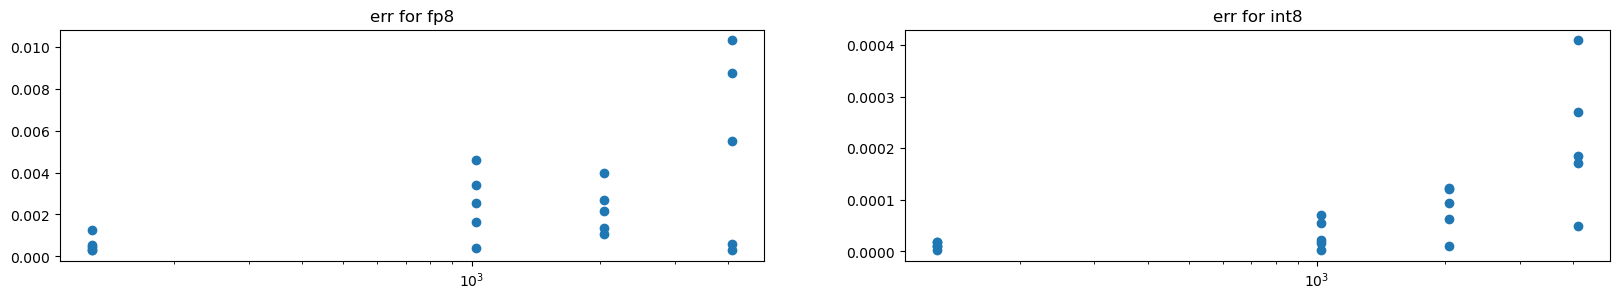

In [93]:
size = [128, 1024, 2048, 4096]*5
plt.figure(figsize=(20,3))

errors = [dot_error(0.01, s) for s in size]

plt.subplot(1,2,1)
plt.scatter(size, [e[0] for e in errors])
plt.xscale('log')
plt.title("err for fp8")

plt.subplot(1,2,2)
plt.scatter(size, [e[1] for e in errors])
plt.xscale('log')
plt.title("err for int8")


借助上述代码，我们很快便发现了浮点数量化误差随着向量长度而增长。由于该误差是一个随机变量，我们可以能通过研究其范围来给出结论。为了更好的观察这种计算误差，我们引入信噪比：
$$ SNR = 10 \times \log_{10} \frac{\sum{signal_i^2} }{\sum{nosie_i^2}}$$

### 整体scaling对信噪比的影响

In [94]:
def calculate_snr(signal, pred):
    signal = np.float64(signal)
    pred = np.float64(pred)
    signal_power = np.mean(signal ** 2)
    noise_power = np.mean((signal - pred) ** 2)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

def dot_error_snr(scale=0.01, size=100, ctx=define_context(4, 3, "ROUND_HALF_UP"), factor=1.0):
    a = np.random.normal(scale=scale, size=[size])
    b = np.random.normal(scale=scale, size=[size])
    
    A = [ctx(x*factor) for x in a]
    B = [ctx(x*factor) for x in b]
    
    C = ctx(0)
    for x in [ x*y for x,y in zip(A,B )]:
        C = C+x
    gt = np.dot(a,b)
    ret = float((C).as_decimal())
    if factor != 1.0:
        ret = ret / factor / factor

    max_a = np.max(np.abs(a))
    max_b = np.max(np.abs(b))
    factor_a = 127/max_a
    factor_b = 127/max_b

    ia = np.int32(np.int8(a*factor_a))
    ib = np.int32(np.int8(b*factor_b))
    iret = float(np.sum(ia*ib))/factor_a/factor_b

    return calculate_snr(gt, ret), calculate_snr(gt, iret)

Text(0.5, 1.0, 'err for int8')

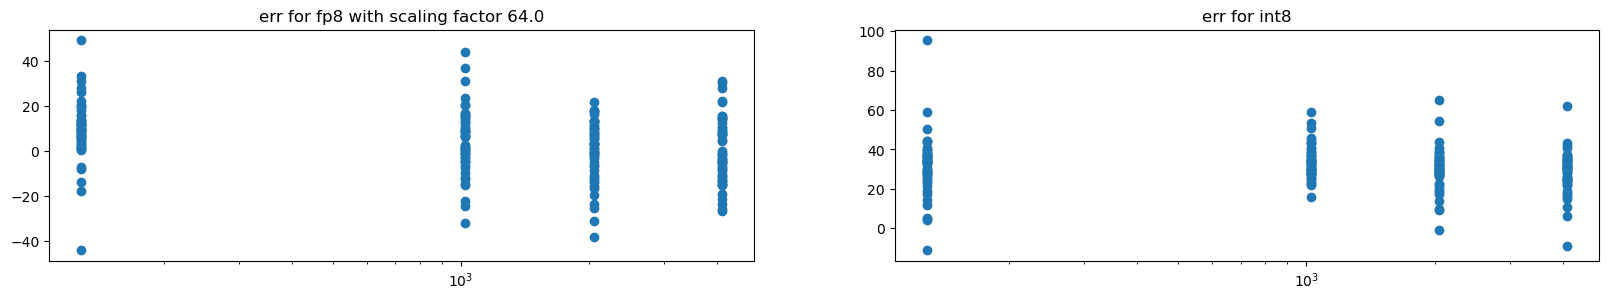

In [95]:
size = [128, 1024, 2048, 4096]*50
plt.figure(figsize=(20,3))

errors = [dot_error_snr(0.01, s, factor=64.0) for s in size]

plt.subplot(1,2,1)
plt.scatter(size, [e[0] for e in errors])
plt.xscale('log')
plt.title("err for fp8 with scaling factor 64.0")

plt.subplot(1,2,2)
plt.scatter(size, [e[1] for e in errors])
plt.xscale('log')
plt.title("err for int8")

引入tensor level scaling后，肉眼可见int8会比fp8差一些

### 分块Scaling对信噪比的影响

In [97]:
def dot_error_snr_chunk_scaling(scale=0.01, size=100, ctx=define_context(4, 3, "ROUND_HALF_UP"), chunksize=None):
    a = np.random.normal(scale=scale, size=[size])
    b = np.random.normal(scale=scale, size=[size])
    A, B = [], []
    chunksize = 128 if chunksize is None else chunksize

    acc = 0
    acc_ctx = define_context(8, 23, "ROUND_HALF_UP")
    iacc = 0
    for offset in range(0, len(a), chunksize):
        slice_a = a[offset:offset+chunksize]
        max_a = np.max(np.abs(slice_a))
        factor_a = 224 / max_a

        slice_b = b[offset:offset+chunksize]
        max_b = np.max(np.abs(b[offset:offset+chunksize]))
        factor_b = 224 / max_b
        
        C = acc_ctx(0.0)
        for x,y in zip(slice_a, slice_b):
            try:
                A = ctx(x*factor_a)
                B = ctx(y*factor_b)
                A = acc_ctx(float(A.as_decimal()))
                B = acc_ctx(float(B.as_decimal()))
                C = C + A*B
            except:
                print("==== error:", x, y, A, B)
        C = float((C).as_decimal()) / factor_a / factor_b
        c = np.sum(slice_a * slice_b)
        acc += C

        factor_a = 127 / max_a
        factor_b = 127 / max_b
        islice_a = np.int32(np.int8(slice_a * factor_a))
        islice_b = np.int32(np.int8(slice_b * factor_b))
        iacc += float(np.sum(islice_a*islice_b))/factor_a/factor_b
    gt = np.dot(a,b)
    ret = acc
    iret = iacc
    return calculate_snr(gt, ret), calculate_snr(gt, iret)

==== error: -1.9286153264532807e-08 0.013583454710714968 1 0000 000 0 1101 100
==== error: 0.008715197957080076 -9.696976571500512e-08 0 10000101 00100000000000000000000 1 0000 000
==== error: 0.0002930989388271229 -5.552059462813121e-08 0 10000000 00100000000000000000000 1 0000 000
==== error: -1.2257351182176582e-07 -0.011580856881096016 1 0000 000 1 1101 011


Text(0.5, 1.0, 'err for int8 with block-wise scaling')

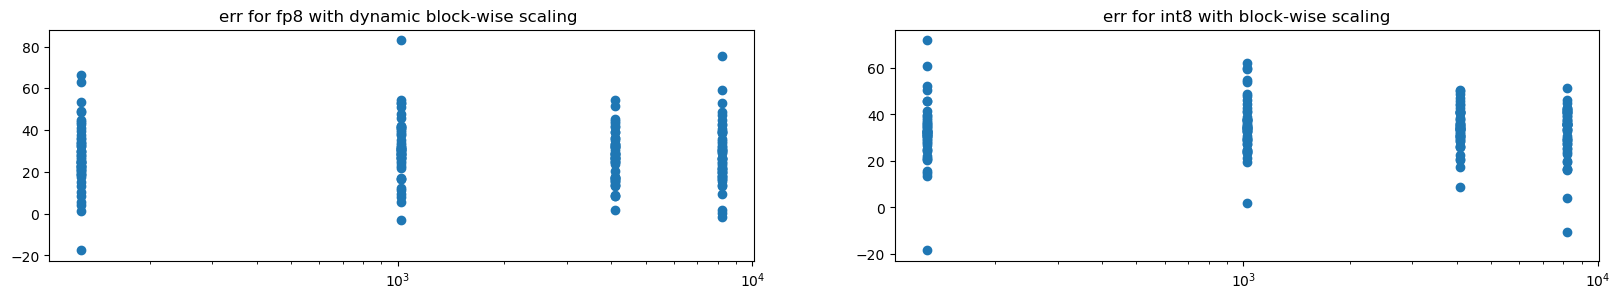

In [98]:
size = [128, 1024, 4096, 8192]*50
plt.figure(figsize=(20,3))

errors = [dot_error_snr_chunk_scaling(0.01, s, chunksize=128) for s in size]

plt.subplot(1,2,1)
plt.scatter(size, [e[0] for e in errors])
plt.xscale('log')
plt.title("err for fp8 with dynamic block-wise scaling ")

plt.subplot(1,2,2)
plt.scatter(size, [e[1] for e in errors])
plt.xscale('log')
plt.title("err for int8 with block-wise scaling")

可以发现，经过仔细调整int8的量化策略，int8可以在向量内积上达到与fp8类似的信噪比。需要注意的是保证乘法运算使用高精度进行,避免numpy库中int8乘法导致的溢出。硬件会自动提升精度来进行运算，所以此处的处理符合硬件行为。注意到FP8运算时没有进行精度提升，我们将类似逻辑应用到FP8上，看是否有精度提升

# 浮点数向量内积计算的量化误差分析

根据前边的分析和说明，我们认为影响量化误差的主要因素有两个：
1. 向量长度，已经在前一节进行了初步验证，本节将进行定性和定量分析；
2. 向量之间的相关性，本节将进行系统性分析；

## 生成两个相关的随机向量

可以通过在第二个向量中混合第一个向量来人为制造相关性，代码如下：

In [322]:
def generate_correlated_vectors_simple(n_dim, scale, rho):
    z1 = np.random.normal(0, scale, (n_dim,))
    z2 = np.random.normal(0, scale, (n_dim,))
    return z1, rho * z1 + (1 - rho) * z2

验证一下该方法的正确性：

In [323]:
a, b = generate_correlated_vectors_simple(1000, 0.1, 0.2)
np.dot(a,b) / np.sqrt( np.dot(a,a) * np.dot(b,b) )

np.float64(0.23483392480674695)

In [324]:
a, b = generate_correlated_vectors_simple(1000, 0.5, 0.03)
np.dot(a,b) / np.sqrt( np.dot(a,a) * np.dot(b,b) )

np.float64(0.059835243403025956)

In [399]:
import numpy as np

def generate_correlated_vectors_simple(size, scale, rho):
    # 定义均值和协方差矩阵
    mean = [0, 0]
    cov = [[1, rho], [rho, 1]]
    
    # 生成样本
    samples = np.random.multivariate_normal(mean, cov, size)
    
    # 提取两个向量
    vector_x = samples[:, 0]*scale
    vector_y = samples[:, 1]*scale
    
    return vector_x, vector_y

In [402]:
a, b = generate_correlated_vectors_simple(1000, 0.1, 0.2)
np.dot(a,b) / np.sqrt( np.dot(a,a) * np.dot(b,b) )

np.float64(0.18596320251898074)

通过两个测试发现上述方法基本可用，但是相关性误差略高。不过不影响我们得到一些想要的结论。

## 两个向量量化后计算内积的量化误差

In [403]:
def calc_dot_error(a, b, ctx=define_context(4, 3, "ROUND_HALF_UP"), factor=64.0):
    A = [ctx(x*factor) for x in a]
    B = [ctx(x*factor) for x in b]
    C = ctx(0)
    for x in [ x*y for x,y in zip(A,B )]:
        C = C+x
    gt = np.dot(a,b)
    ret = float((C).as_decimal())/factor/factor
    return np.abs(ret-gt)

def correlated_dot_error(scale=0.01, size=100, rho=0.1, ctx=define_context(4, 3, "ROUND_HALF_UP")):
    a, b = generate_correlated_vectors_simple(size, scale, rho)
    return calc_dot_error(a, b, ctx=ctx)

首先定性分析下向量长度、向量相关性与不同量化方法的影响：

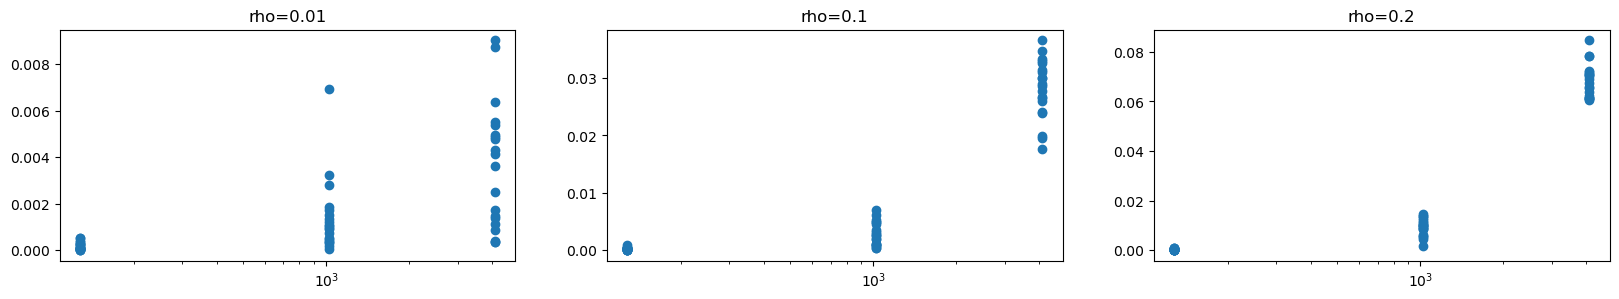

In [404]:
size = [128, 1024, 4096]*20

rho = 0.01
plt.figure(figsize=(20,3))
plt.subplot(1,3,1)
plt.scatter(size, [correlated_dot_error(0.01, s, rho) for s in size], label=f"rho={rho}")
plt.xscale('log')
plt.title(f"rho={rho}")

rho = 0.1
plt.subplot(1,3,2)
plt.scatter(size, [correlated_dot_error(0.01, s, rho) for s in size], label=f"rho={rho}")
plt.xscale('log')
plt.title(f"rho={rho}")

rho = 0.2
plt.subplot(1,3,3)
plt.scatter(size, [correlated_dot_error(0.01, s, rho) for s in size], label=f"rho={rho}")
plt.xscale('log')
plt.title(f"rho={rho}")
plt.show()

实验测试了三个不同的向量长度下(128、1024和4096)，FP8的计算误差。可以发现，不管是哪一个向量长度，相关性越大，计算误差越大。为了更加清晰直观的观察误差，我们使用箱图（boxplot）来观察信噪比：

In [405]:
def calc_dot_snr(a, b, ctx=define_context(4, 3, "ROUND_HALF_UP"), factor=64.0):
    A = [ctx(x*factor) for x in a]
    B = [ctx(x*factor) for x in b]
    C = ctx(0)
    for x in [ x*y for x,y in zip(A,B )]:
        C = C+x
    gt = np.dot(a,b)
    ret = float((C).as_decimal())/factor/factor
    return calculate_snr(gt, ret)

def correlated_dot_snr(scale=0.01, size=100, rho=0.1, ctx=define_context(4, 3, "ROUND_HALF_UP"), factor=64.0):
    a, b = generate_correlated_vectors_simple(size, scale, rho)
    return calc_dot_snr(a, b, ctx=ctx, factor=factor)

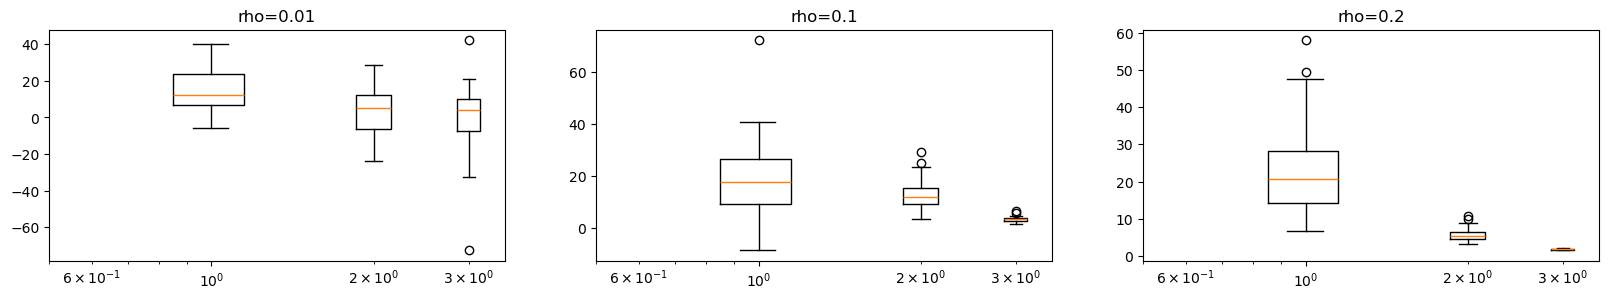

In [406]:
size = [128, 1024, 4096]
samples = 50

rho = 0.01
plt.figure(figsize=(20,3))
plt.subplot(1,3,1)
plt.boxplot([[correlated_dot_snr(0.01, s, rho) for _ in range(samples)] for s in size], label=f"rho={rho}")
plt.xticks(ticks=[x+1 for x in range(len(size))],labels=size)
plt.xscale('log')
plt.title(f"rho={rho}")

rho = 0.1
plt.subplot(1,3,2)
plt.boxplot([[correlated_dot_snr(0.01, s, rho) for _ in range(samples)] for s in size], label=f"rho={rho}")
plt.xticks(ticks=[x+1 for x in range(len(size))],labels=size)
plt.xscale('log')
plt.title(f"rho={rho}")

rho = 0.2
plt.subplot(1,3,3)
plt.boxplot([[correlated_dot_snr(0.01, s, rho) for _ in range(samples)] for s in size], label=f"rho={rho}")
plt.xticks(ticks=[x+1 for x in range(len(size))],labels=size)
plt.xscale('log')
plt.title(f"rho={rho}")
plt.show()

Text(0.5, 1.0, 'vector size=4096, rho=0.05/0.1/0.2')

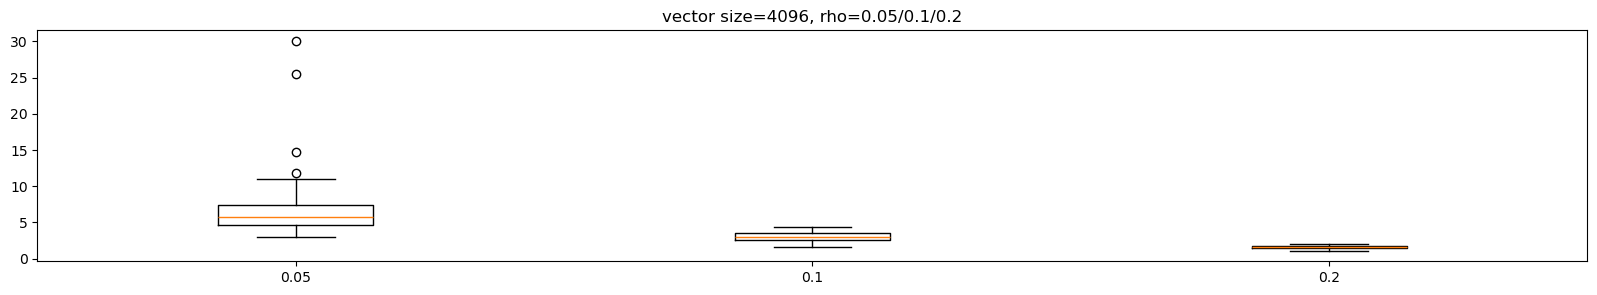

In [388]:
rhos = [0.05, 0.1, 0.2]
samples = 50

rho = 0.01
plt.figure(figsize=(20,3))
plt.boxplot([[correlated_dot_snr(0.01, 4096, rho) for _ in range(samples)] for rho in rhos])
plt.xticks(ticks=[x+1 for x in range(len(rhos))],labels=rhos)
plt.title(f"vector size=4096, rho=0.05/0.1/0.2")

/tmp/ipykernel_128565/833229588.py:6: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


Text(0.5, 1.0, 'vector size=4096, rho=0.1, factor=32/64/128')

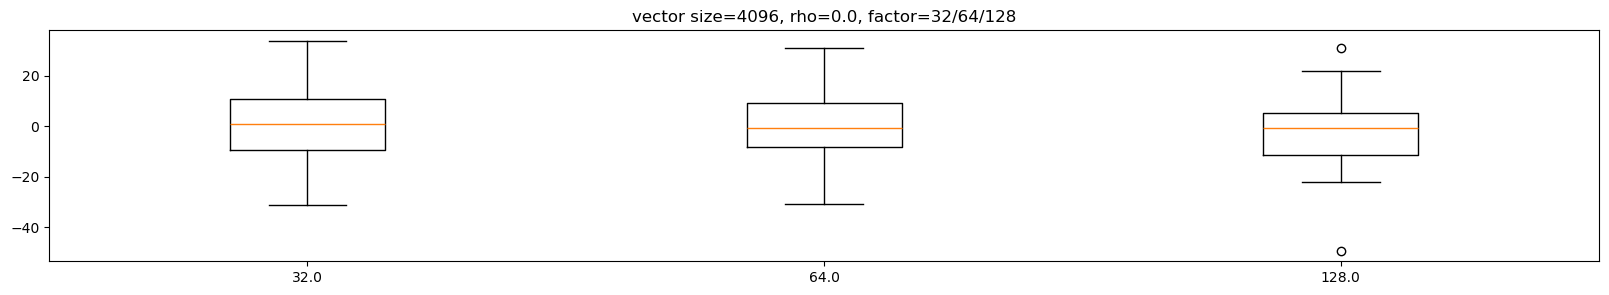

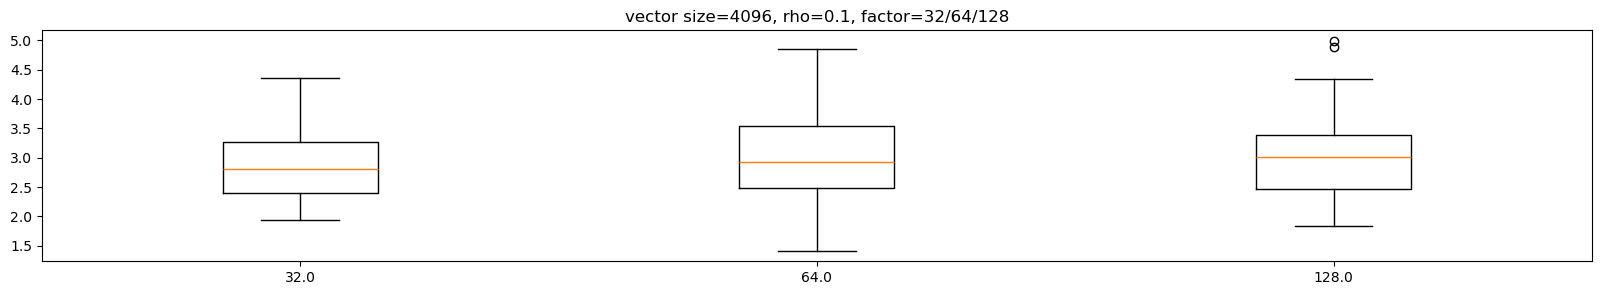

In [390]:
factors = [32., 64., 128.]
samples = 50

plt.figure(figsize=(20,3))
plt.boxplot([[correlated_dot_snr(0.01, 4096, rho=0.0, factor=factor) for _ in range(samples)] for factor in factors])
plt.xticks(ticks=[x+1 for x in range(len(factors))],labels=factors)
plt.title(f"vector size=4096, rho=0.0, factor=32/64/128")

plt.figure(figsize=(20,3))
plt.boxplot([[correlated_dot_snr(0.01, 4096, rho=0.1, factor=factor) for _ in range(samples)] for factor in factors])
plt.xticks(ticks=[x+1 for x in range(len(factors))],labels=factors)
plt.title(f"vector size=4096, rho=0.1, factor=32/64/128")

Text(0.5, 1.0, 'vector size=4096, rho=0.1, chunksizes=[1024, 128, 64]')

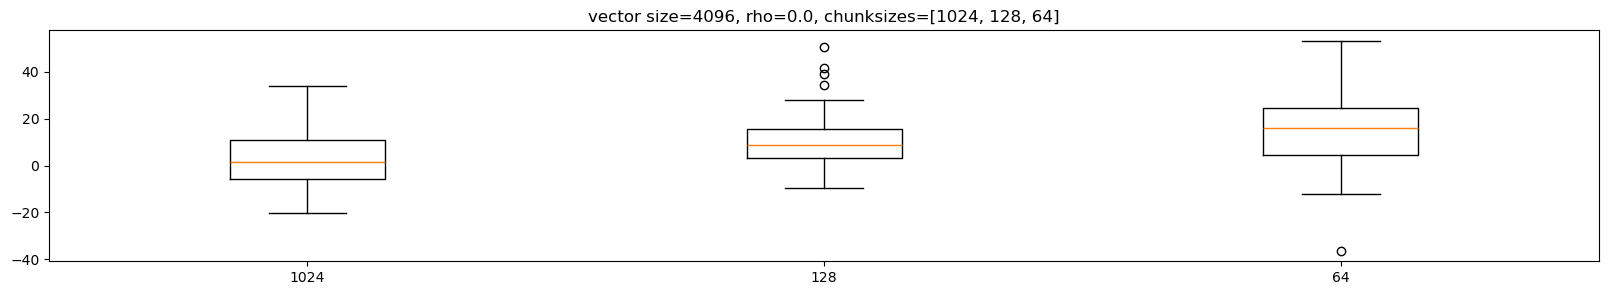

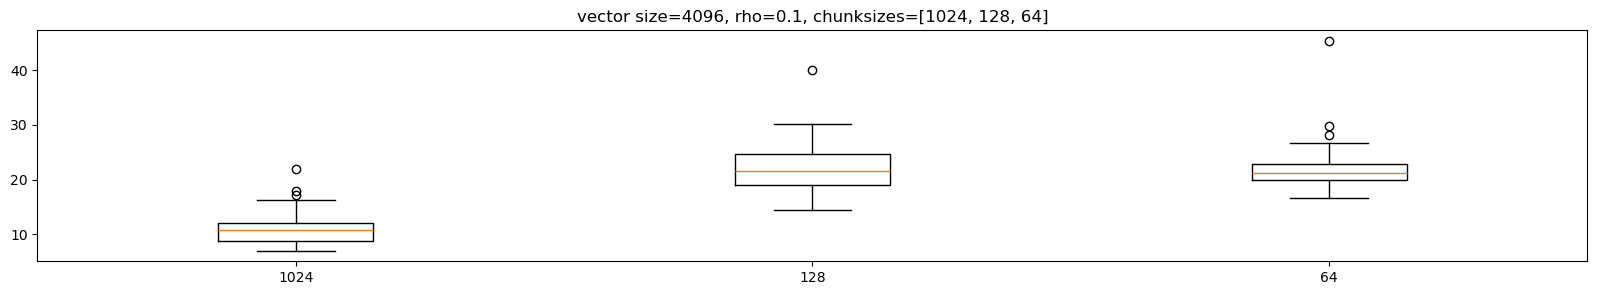

In [386]:
def calc_dot_snr_chunk(a, b, ctx=define_context(4, 3, "ROUND_HALF_UP"), factor=64.0, chunksize=None):
    A = [ctx(x*factor) for x in a]
    B = [ctx(x*factor) for x in b]
    chunksize = len(A) if chunksize is None else chunksize
    acc = 0.0
    cnt = 0
    C = ctx(0)
    for x in [ x*y for x,y in zip(A,B )]:
        C = C+x
        cnt += 1
        if cnt % chunksize == 0:
            acc = acc + float((C).as_decimal())
            C = ctx(0)
    gt = np.dot(a,b)
    ret = acc + float((C).as_decimal())
    if factor != 1.0:
        ret = ret / factor / factor
    return calculate_snr(gt, ret)

def correlated_dot_snr_chunk(scale=0.01, size=100, rho=0.1, ctx=define_context(4, 3, "ROUND_HALF_UP"), chunksize=None):
    a, b = generate_correlated_vectors_simple(size, scale, rho)
    return calc_dot_snr_chunk(a, b, ctx=ctx, chunksize=chunksize)

chunksizes = [1024, 128, 64]
samples = 50

plt.figure(figsize=(20,3))
plt.boxplot([[correlated_dot_snr_chunk(0.01, 4096, rho=0.0, chunksize=chunksize) for _ in range(samples)] for chunksize in chunksizes])
plt.xticks(ticks=[x+1 for x in range(len(chunksizes))],labels=chunksizes)
plt.title(f"vector size=4096, rho=0.0, chunksizes=[1024, 128, 64]")

plt.figure(figsize=(20,3))
plt.boxplot([[correlated_dot_snr_chunk(0.01, 4096, rho=0.1, chunksize=chunksize) for _ in range(samples)] for chunksize in chunksizes])
plt.xticks(ticks=[x+1 for x in range(len(chunksizes))],labels=chunksizes)
plt.title(f"vector size=4096, rho=0.1, chunksizes=[1024, 128, 64]")

/home/reiase/workspace/ieee754_simulation/simfloat/core.py:1225: RuntimeWarning: overflow encountered in scalar negative
  return '-' + decint2binstr(-n)


==== error: -4.028493495376413e-08 -0.008378449610465835 1 0000 000 1 1100 101
==== error: -3.062303856017909e-08 -0.00017806052466798046 1 0000 000 1 0111 010


Text(0.5, 1.0, 'vector size=4096, rho=0.1, chunksizes=[1024, 128, 64]')

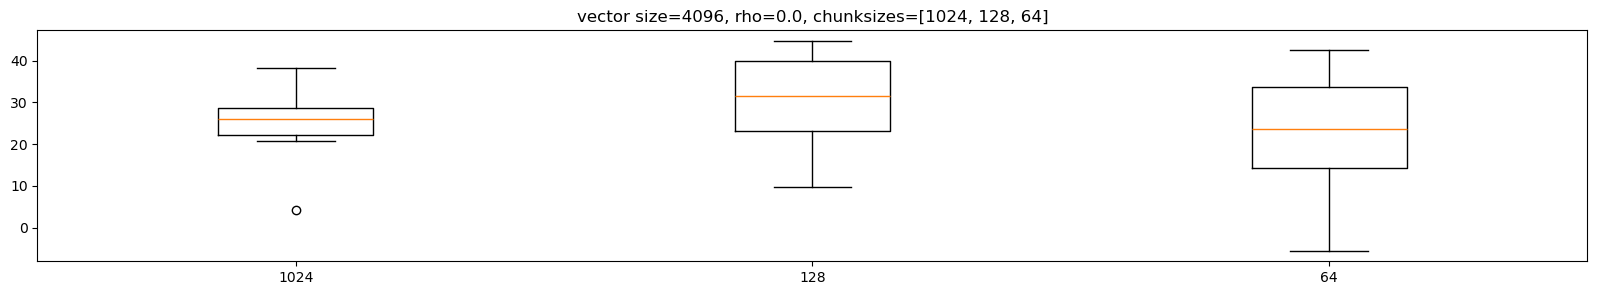

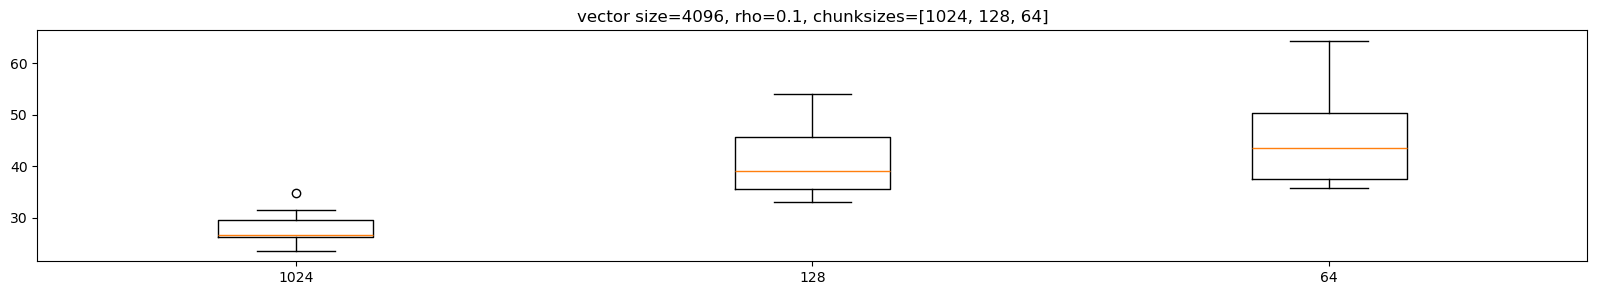

In [391]:
def calc_dot_snr_chunk_scaling(a, b, ctx=define_context(4, 3, "ROUND_HALF_UP"), factor=64.0, chunksize=None):
    A = [ctx(x*factor) for x in a]
    B = [ctx(x*factor) for x in b]
    chunksize = 128 if chunksize is None else chunksize

    acc = 0
    acc_ctx = define_context(8, 8, "ROUND_HALF_UP")
    for offset in range(0, len(a), chunksize):
        slice_a = a[offset:offset+chunksize]
        max_a = np.max(np.abs(slice_a))
        factor_a = 224 / max_a

        slice_b = b[offset:offset+chunksize]
        max_b = np.max(np.abs(b[offset:offset+chunksize]))
        factor_b = 224 / max_b
        
        C = acc_ctx(0.0)
        for x,y in zip(slice_a, slice_b):
            try:
                A = ctx(x*factor_a)
                B = ctx(y*factor_b)
                A = acc_ctx(float(A.as_decimal()))
                B = acc_ctx(float(B.as_decimal()))
                C = C + A*B
            except:
                print("==== error:", x, y, A, B)
        C = float((C).as_decimal()) / factor_a / factor_b
        c = np.sum(slice_a * slice_b)
        acc += C
    gt = np.dot(a,b)
    ret = acc
    return calculate_snr(gt, ret)

def correlated_dot_snr_chunk_scaling(scale=0.01, size=100, rho=0.1, ctx=define_context(4, 3, "ROUND_HALF_UP"), chunksize=None):
    a, b = generate_correlated_vectors_simple(size, scale, rho)
    return calc_dot_snr_chunk_scaling(a, b, ctx=ctx, chunksize=chunksize)

chunksizes = [1024, 128, 64]
samples = 10

plt.figure(figsize=(20,3))
plt.boxplot([[correlated_dot_snr_chunk_scaling(0.01, 4096, rho=0.0, chunksize=chunksize) for _ in range(samples)] for chunksize in chunksizes])
plt.xticks(ticks=[x+1 for x in range(len(chunksizes))],labels=chunksizes)
plt.title(f"vector size=4096, rho=0.0, chunksizes=[1024, 128, 64]")

plt.figure(figsize=(20,3))
plt.boxplot([[correlated_dot_snr_chunk_scaling(0.01, 4096, rho=0.1, chunksize=chunksize) for _ in range(samples)] for chunksize in chunksizes])
plt.xticks(ticks=[x+1 for x in range(len(chunksizes))],labels=chunksizes)
plt.title(f"vector size=4096, rho=0.1, chunksizes=[1024, 128, 64]")

/tmp/ipykernel_128565/833229588.py:6: RuntimeWarning: invalid value encountered in scalar divide
  snr = 10 * np.log10(signal_power / noise_power)
/tmp/ipykernel_128565/833229588.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  snr = 10 * np.log10(signal_power / noise_power)


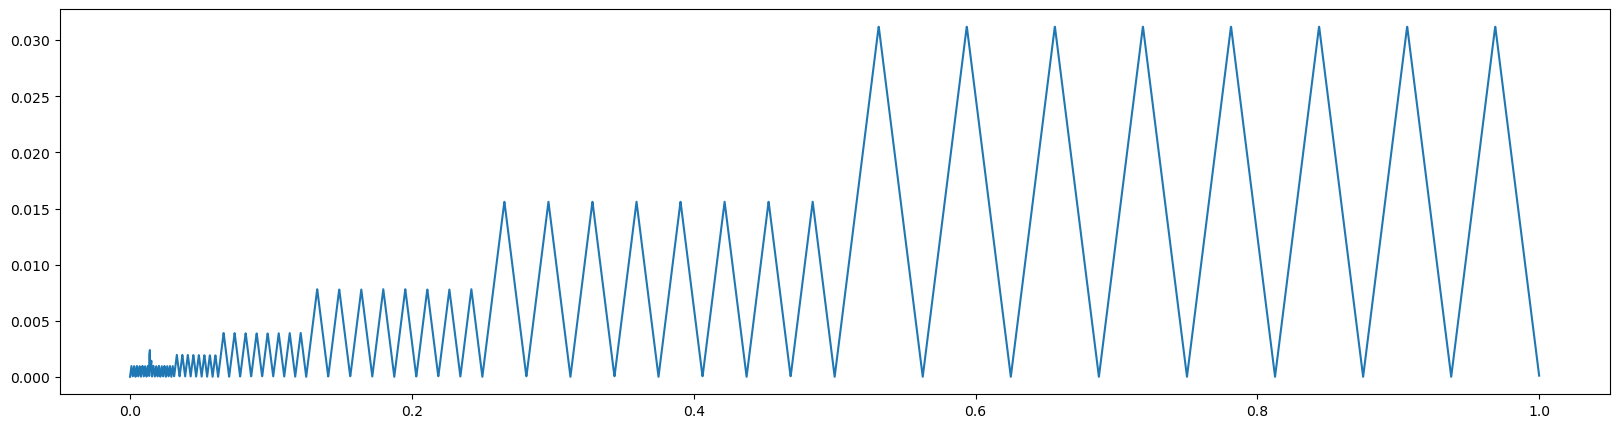

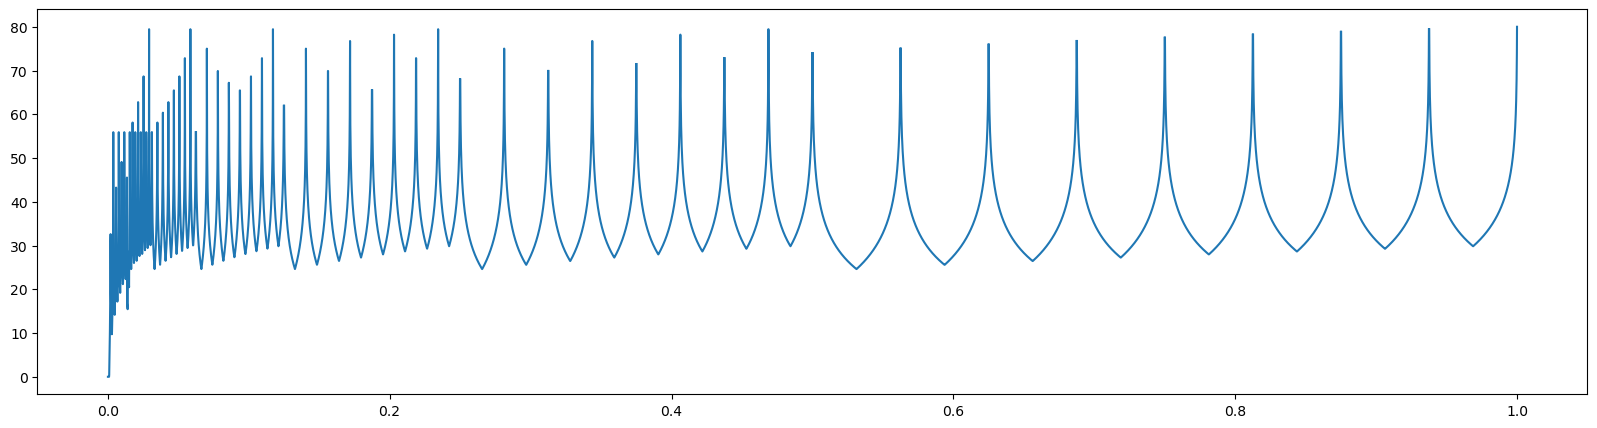

In [396]:
ctx = define_context(4, 3, "ROUND_HALF_UP")
nums = [x/10000 for x in range(10000)]
fp8s = [float(ctx(x).as_decimal()) for x in nums]

plt.figure(figsize=(20,5))
plt.plot(nums, [np.abs(x-y) for x,y in zip(nums, fp8s)])

plt.figure(figsize=(20,5))
plt.plot(nums, [calculate_snr(x, y) for x,y in zip(nums, fp8s)])